# Gaussian Mixture Model and Maximum Likelihood Prediction

In this notebook, I will show how to use Gaussian Mixture Model (GMM) to predict the likelihood of a given point. The likelihood is the probability of the point being generated by the GMM. The GMM is trained using the Expectation-Maximization (EM) algorithm and also kmeans (two different initializations). The likelihood is calculated using the trained GMM.

The notebook is organized as follows:
1. Load the data
2. Train the GMM using KMeans initialization
3. Train the GMM using EM initialization
4. Predict the likelihood of a given point
5. Conclusion

In [151]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
from collections import Counter # for counting the number of instances in each cluster
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.mixture._gaussian_mixture import _compute_precision_cholesky

In [152]:
train_data = pd.read_csv('../data/train_grouped.csv')
test_data = pd.read_csv('../data/test_grouped.csv')

X_train = train_data['coefficients'].apply(lambda x: np.array(eval(x)))
X_test = test_data['coefficients'].apply(lambda x: np.array(eval(x)))

y_train = train_data['digit']
y_test = test_data['digit']

In [153]:
n_components = 3

In [154]:
n_components = [n_components] * 10 # 10 digits to classify

In [155]:
covariance_types = ['full', 'tied', 'diag', 'spherical']

In [156]:
covar = 'full'

## Kmeans GMM

In [157]:
gmm_models = []

In [158]:
# ------------------ Training KMeans GMM models ------------------
# Iterate over each digit to train a separate GMM
for target_digit in tqdm(range(10), desc='Training GMMs for each digit', position=0, colour='green'):
    # Extract training samples (utterances) corresponding to the current digit
    digit_utterances = X_train[y_train == target_digit]
    
    # Flatten the list of utterances into a single array of MFCC feature vectors
    mfccs = np.vstack([np.array(utterance) for utterance in digit_utterances])
    
    # Use KMeans to initialize GMM parameters
    kmeans = KMeans(n_clusters=n_components[target_digit])  # Define number of components for the digit
    kmeans.fit(mfccs)  # Fit KMeans to the MFCCs
    cluster_labels = kmeans.labels_  # Cluster assignments for each MFCC
    
    # Initialize lists to store GMM parameters for this digit
    cluster_weights = []  # Mixture component weights
    cluster_means = []  # Mixture component means
    cluster_covariances = []  # Mixture component covariances
    
    # If covariance type is 'tied', precompute the tied covariance matrix
    if covar == 'tied':
        # Centralize the data across all clusters to compute the tied covariance
        mfccs_demeaned = mfccs - np.mean(mfccs, axis=0)
        tied_cov = np.cov(mfccs_demeaned, rowvar=False)

    # Compute parameters for each cluster
    for cluster in range(n_components[target_digit]):
        # Extract all feature vectors assigned to the current cluster
        cluster_mfccs = mfccs[cluster_labels == cluster]
        
        # Compute the weight of the cluster as the fraction of total samples
        cluster_weight = len(cluster_mfccs) / len(mfccs)
        
        # Compute the mean vector for the cluster
        cluster_mean = np.mean(cluster_mfccs, axis=0)
        
        # Compute the covariance matrix based on the specified type
        if covar == 'full':  # Full covariance matrix
            cluster_cov = np.cov(cluster_mfccs, rowvar=False)
        elif covar == 'diag':  # Diagonal covariance (variances only)
            cluster_cov = np.diag(np.var(cluster_mfccs, axis=0))
        elif covar == 'spherical':  # Spherical covariance (single variance across all dimensions)
            var = np.var(cluster_mfccs - cluster_mean)  # Variance of all deviations
            cluster_cov = np.identity(cluster_mean.shape[0]) * var
        elif covar == 'tied':  # Shared covariance matrix across all components
            cluster_cov = tied_cov
        
        # Append computed parameters to respective lists
        cluster_weights.append(cluster_weight)
        cluster_means.append(cluster_mean)
        if covar != 'tied':  # For tied covariance, we use the precomputed matrix
            cluster_covariances.append(cluster_cov)
    
    # Convert lists to numpy arrays for compatibility with sklearn GMM
    cluster_weights = np.array(cluster_weights)  # Array of component weights
    cluster_means = np.array(cluster_means)  # Array of component means
    if covar != 'tied':
        cluster_covariances = np.array(cluster_covariances)  # Array of covariance matrices
    
    # Create and configure a GaussianMixture object
    gmm = GaussianMixture(n_components=n_components[target_digit], covariance_type='full')  # GMM instance
    gmm.weights_ = cluster_weights  # Assign precomputed weights
    gmm.means_ = cluster_means  # Assign precomputed means
    
    if covar != 'tied':  # Non-tied covariance matrices
        gmm.covariances_ = cluster_covariances
        gmm.precisions_cholesky_ = _compute_precision_cholesky(cluster_covariances, 'full')
    else:  # Tied covariance matrix
        gmm.covariances_ = tied_cov
        gmm.precisions_cholesky_ = _compute_precision_cholesky(tied_cov, 'tied')
    
    # Append the trained GMM model for this digit to the list
    gmm_models.append(gmm)


Training GMMs for each digit:   0%|          | 0/10 [00:00<?, ?it/s]

In [159]:
# ------------------- Prediction -------------------
list_predictions = np.zeros(len(X_test))  # Initialize predictions array

for idx, utterance in enumerate(X_test):
    mfccs = np.array(utterance)
    
    # Compute likelihoods for each GMM
    digit_likelihoods = [np.sum(gmm.score_samples(mfccs)) for gmm in gmm_models]
    predicted_digit = np.argmax(digit_likelihoods)
    list_predictions[idx] = predicted_digit


Accuracy: 0.88


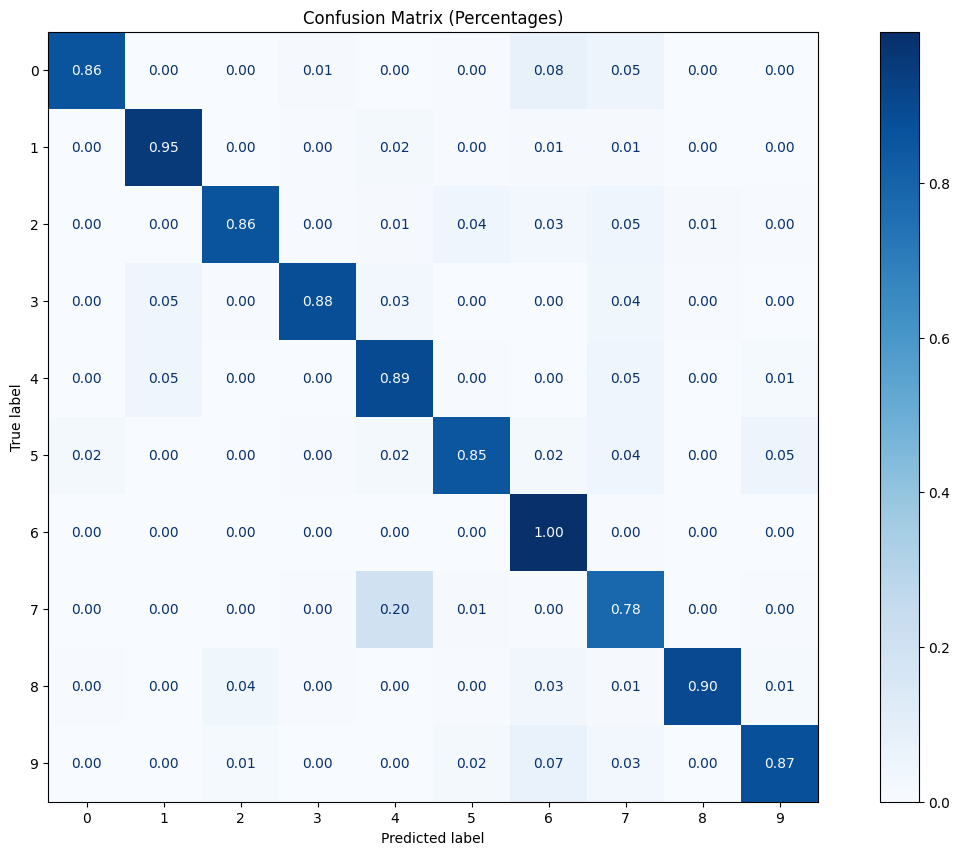

In [160]:
# ------------------- Evaluate -------------------
accuracy = accuracy_score(y_test.to_numpy(), list_predictions.astype(int))
print(f'Accuracy: {accuracy:.2f}')

# ------------------- Compute Confusion Matrix -------------------
cm = confusion_matrix(y_test, list_predictions.astype(int))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (percentages)

# ------------------- Display Confusion Matrix -------------------
fig, ax = plt.subplots(figsize=(16, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[str(i) for i in range(10)])
disp.plot(values_format=".2f", ax=ax, cmap='Blues')
plt.title('Confusion Matrix (Percentages)')
plt.show()

# EM GMM

In [161]:
gmm_models = []

In [162]:
# ------------------- Training EM GMMs -------------------
for target_digit in tqdm(range(10), desc='Training GMMs for each digit', position=0, colour='green', unit='digit', unit_scale=True, dynamic_ncols=True, smoothing=0.1):
    digit_utterances = X_train[y_train == target_digit]
    
    # ------------------- get all mfccs of the target digit -------------------
    mfccs = np.vstack([np.array(utterance) for utterance in digit_utterances])
    
    # ------------------- fit GMM -------------------
    gmm = GaussianMixture(n_components=n_components[target_digit], covariance_type='tied')
    gmm.fit(mfccs)
    gmm_models.append(gmm)

Training GMMs for each digit:   0%|          | 0.00/10.0 [00:00<?, ?digit/s]

In [163]:
# ------------------- Prediction -------------------
list_predictions = np.zeros(len(X_test))  # Initialize predictions array
for idx, utterance in enumerate(X_test):
    mfccs = np.array(utterance)
    
    # ------------------- predict -------------------
    digit_likelihoods = np.array([gmm.score_samples(mfccs) for gmm in gmm_models])
    predicted_digit = np.argmax(np.sum(digit_likelihoods, axis=1))
    list_predictions[idx] = predicted_digit

In [164]:
list_predictions

array([0., 0., 0., ..., 9., 9., 9.])

Accuracy: 0.89


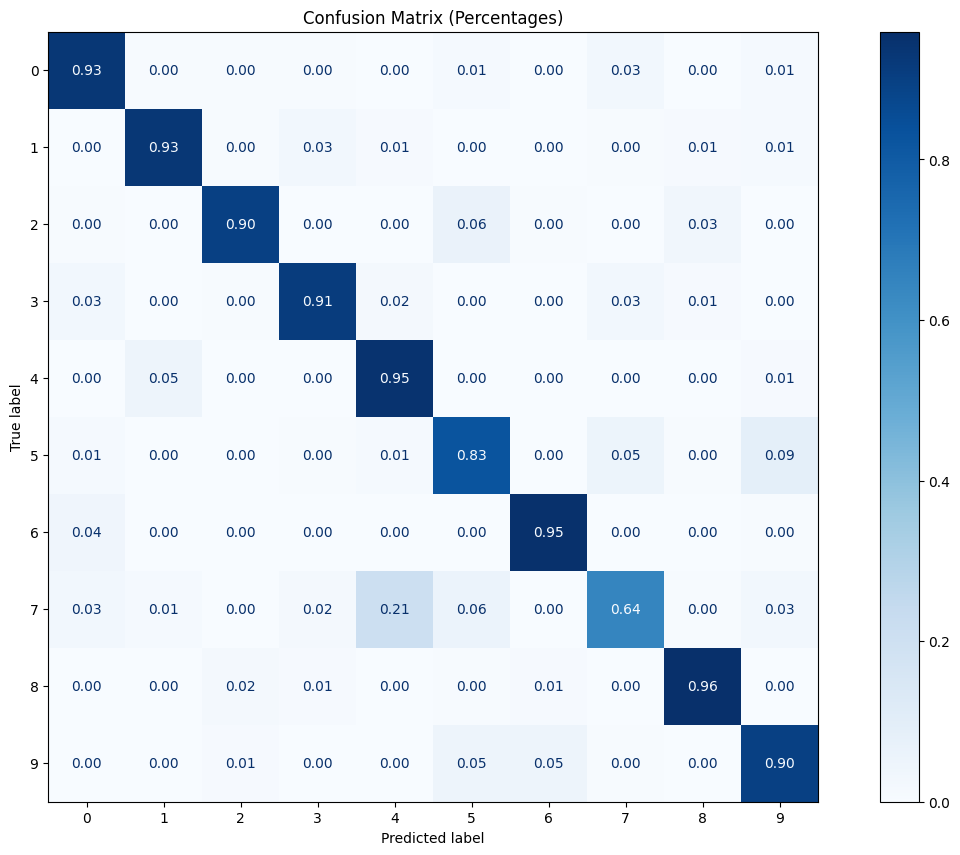

In [165]:
# ------------------- Evaluate -------------------
accuracy = accuracy_score(y_test.to_numpy(), list_predictions.astype(int))
print(f'Accuracy: {accuracy:.2f}')

# ------------------- Compute Confusion Matrix -------------------
cm = confusion_matrix(y_test, list_predictions.astype(int))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row (percentages)

# ------------------- Display Confusion Matrix -------------------
fig, ax = plt.subplots(figsize=(16, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[str(i) for i in range(10)])
disp.plot(values_format=".2f", ax=ax, cmap='Blues')
plt.title('Confusion Matrix (Percentages)')
plt.show()